<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_06_05_survival_analysis_dynamic_joint_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.5 Dynamic Joint Models



A **Dynamic Joint Model (Dynamic JM)** is an extension of the standard **shared random effects joint model** that enables real-time, individualized risk prediction for a future event (e.g., death, disease progression) by updating predictions as new longitudinal data (eg. biomarker measurements) become available. In other words, it turns the joint model into a **dynamic prediction tool**, not just a static association estimator.

At any time point $t$ during follow-up, after observing a patient’s longitudinal history $\mathcal{Y}_i(t) = \{ y_i(s) : 0 \leq s \leq t \}$, we can compute the conditional probability of surviving beyond a future time $u > t$\*\*:

$$
\pi_i(u \mid t) = P(T_i > u \mid T_i > t, \mathcal{Y}_i(t), \mathcal{D}_n)
$$

-   $T_i$: event time for subject $i$
-   $\mathcal{Y}_i(t)$: all longitudinal measurements up to time $t$
-   $\mathcal{D}_n$: full dataset used to fit the joint model (provides parameter estimates)
-   $u - t$: prediction horizon (e.g., 6 months, 1 year)

This probability **dynamically updates** as $t$ increases and more biomarker data are collected.


### Why “Dynamic”?


-   **Static models** (e.g., baseline Cox) give one risk estimate at enrollment.
-   **Time-dependent Cox** uses observed biomarker values but ignores measurement error and trajectory.
-   **Dynamic JM** uses the **entire history** of noisy measurements to infer the **true underlying trajectory** (via the mixed model) and **propagates uncertainty** into the survival prediction.


### Mathematical Foundation


Under the standard joint model with **current-value association**, the dynamic survival probability is:

$$
\pi_i(u \mid t) = \frac{
  \int P(T_i > u \mid b_i, \theta_S) \cdot p(b_i \mid T_i > t, \mathcal{Y}_i(t), \theta)
  \, db_i
}{
  \int P(T_i > t \mid b_i, \theta_S) \cdot p(b_i \mid \mathcal{Y}_i(t), \theta_L)
  \, db_i
}
$$

-   The numerator: probability of surviving beyond $u$, given survival to $t$ and biomarker history.
-   The denominator: ensures proper conditioning on survival to $t$.
-   $p(b_i \mid \cdot)$: posterior distribution of random effects given observed data (updated via Bayes’ rule).
-   $\theta$: model parameters estimated from the full cohort.

This integral is computed numerically (e.g., Monte Carlo or Gauss-Hermite quadrature).


### ️ Key Features of Dynamic JM


| Feature | Description |
|----------------------------|--------------------------------------------|
| **Personalized** | Tailored to each patient’s biomarker trajectory |
| **Uncertainty-aware** | Accounts for measurement error, parameter uncertainty, and random effects |
| **Time-adaptive** | Risk estimate evolves as new data arrive |
| **Clinically actionable** | Supports decisions like treatment escalation or screening intensity |


### Clinical Use Case Example


> **Context**: Heart failure patients monitored via repeated **NT-proBNP** (a cardiac biomarker).\
> **Goal**: Predict 6-month risk of hospitalization or death.
>
> -   At baseline: risk = 15%\
> -   After 3 months: NT-proBNP rising → dynamic JM updates risk to 38%\
> -   Clinician intensifies therapy based on updated risk\
> -   After 6 months: biomarker stabilizes → risk drops to 22%

This **feedback loop** between monitoring and prediction is the power of dynamic JM.

###️ Practical Considerations

-   **Model must be well-calibrated**—poor longitudinal fit → poor predictions.
-   **Prediction horizon matters**: short horizons (3–6 months) are more reliable.
-   **Computation**: Real-time use may require pre-fitting and caching.
-   **Missing data**: Handled naturally by the mixed model (under MAR assumption).


### Relation to Standard JM


| Aspect | Standard JM | Dynamic JM |
|------------------|-----------------------------|-------------------------|
| Goal | Estimate association ( $\alpha$) | Predict individual risk over time |
| Output | Parameter estimates, p-values | Time-varying survival probabilities |
| Usage | Inference | Decision support, monitoring |
| Built on | Same joint model framework | Same model, but used for prediction |

> Dynamic JM is not a different model—it’s a *use* of the standard joint model for personalized, time-updated prediction.


### Advanced Extensions


-   **Multiple biomarkers**: Multivariate dynamic predictions
-   **Landmarking + JM**: Hybrid approaches for robustness
-   **Deep joint models**: Using RNNs or GPs for nonlinear trajectories (research frontier)


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316561 sha256=40dc767d8548df2b38b0845f726b699959492190fc208b37f3d7941cc122b0d4
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dynamic Joint Model in R


This tutorial explains how to **fit**, **analyze**, and **interpret** a *Dynamic Joint Model* — that is, a joint model where the association between a longitudinal biomarker and survival outcome **changes over time**.



### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'prodlim',
		 'lava',
		 'mstate',
		 'regplot',
		 'cmprskcoxmsm',
		 'GLMMadaptive',
		 'nlme',
		 'lme4',
		 'lattice',
		 'JM',
		 'joineR',
		 'joineRML',
		 'JMbayes2'

		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify Installation

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom

  method         from 
  augment.mjoint broom
  glance.mjoint  broom
  tidy.mjoint    broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk       condSURV riskRegression 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       prodlim           lava         mstate        regplot   cmprskcoxmsm 
          TRUE           TRUE           TRUE           TRUE           TRUE 
  GLMMadaptive           nlme           lme4        lattice             JM 
          TRUE           TRUE           TRUE           TRUE           TRUE 
        joineR       joineRML       JMbayes2 
          TRUE           TRUE           TRUE 


### Load Packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

### Data


The `aids` dataset in `JMbayes2` includes:

* Repeated CD4 cell counts over time (longitudinal marker)
* Survival data (time to death or censoring)

Let’s inspect it:


In [ ]:
%%R
data("aids", package = "JMbayes2")
str(aids)

'data.frame':	1405 obs. of  12 variables:
 $ patient: Factor w/ 467 levels "1","2","3","4",..: 1 1 1 2 2 2 2 3 3 3 ...
 $ Time   : num  17 17 17 19 19 ...
 $ death  : int  0 0 0 0 0 0 0 1 1 1 ...
 $ CD4    : num  10.68 8.43 9.43 6.32 8.12 ...
 $ obstime: int  0 6 12 0 6 12 18 0 2 6 ...
 $ drug   : Factor w/ 2 levels "ddC","ddI": 1 1 1 2 2 2 2 2 2 2 ...
 $ gender : Factor w/ 2 levels "female","male": 2 2 2 2 2 2 2 1 1 1 ...
 $ prevOI : Factor w/ 2 levels "noAIDS","AIDS": 2 2 2 1 1 1 1 2 2 2 ...
 $ AZT    : Factor w/ 2 levels "intolerance",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ start  : int  0 6 12 0 6 12 18 0 2 6 ...
 $ stop   : num  6 12 17 6 12 ...
 $ event  : num  0 0 0 0 0 0 0 0 0 1 ...


In [ ]:
%%R
is.numeric(aids$Time)
is.numeric(aids$event)

###  Fit Longitudinal Submodel


We first model the trajectory of CD4 counts over time:


In [ ]:
%%R
# Longitudinal submodel: CD4 trajectory
lmeFit<- lme(sqrt(CD4) ~ ns(obstime, 2) * drug,
          data = aids,
          random = list(patient = pdDiag(~ ns(obstime, 2))))
summary(lmeFit)

Linear mixed-effects model fit by REML
  Data: aids 
       AIC      BIC    logLik
  2710.414 2762.849 -1345.207

Random effects:
 Formula: ~ns(obstime, 2) | patient
 Structure: Diagonal
        (Intercept) ns(obstime, 2)1 ns(obstime, 2)2 Residual
StdDev:   0.8611308       0.6454098       0.2340706 0.376354

Fixed effects:  sqrt(CD4) ~ ns(obstime, 2) * drug 
                             Value  Std.Error  DF  t-value p-value
(Intercept)              2.5003423 0.06029322 934 41.46971  0.0000
ns(obstime, 2)1         -0.6966503 0.08494332 934 -8.20135  0.0000
ns(obstime, 2)2         -0.3593129 0.09253117 934 -3.88316  0.0001
drugddI                  0.0435203 0.08589166 465  0.50669  0.6126
ns(obstime, 2)1:drugddI  0.2278327 0.12237908 934  1.86170  0.0630
ns(obstime, 2)2:drugddI -0.1546295 0.12785763 934 -1.20939  0.2268
 Correlation: 
                        (Intr) ns(,2)1 ns(,2)2 drgddI n(,2)1:
ns(obstime, 2)1         -0.226                               
ns(obstime, 2)2          0.034 

### Fit a Cox Survival Model  (Survival Submodel)


We model time to death using baseline covariates:


In [ ]:
%%R
# Survival submodel
CoxFit <- coxph(Surv(Time, death) ~ drug+gender, data = aids.id)
summary(CoxFit)

Call:
coxph(formula = Surv(Time, death) ~ drug + gender, data = aids.id)

  n= 467, number of events= 188 

              coef exp(coef) se(coef)      z Pr(>|z|)
drugddI     0.2116    1.2357   0.1462  1.447    0.148
gendermale -0.1708    0.8430   0.2421 -0.705    0.481

           exp(coef) exp(-coef) lower .95 upper .95
drugddI        1.236     0.8093    0.9277     1.646
gendermale     0.843     1.1862    0.5245     1.355

Concordance= 0.536  (se = 0.02 )
Likelihood ratio test= 2.55  on 2 df,   p=0.3
Wald test            = 2.56  on 2 df,   p=0.3
Score (logrank) test = 2.57  on 2 df,   p=0.3



###  Fit a Standard Joint Model


The standard JM links the two submodels assuming a **constant association** between CD4 level and hazard.


In [ ]:
%%R
# default baseline hazard
jmFit_static<- jm(CoxFit, lmeFit, time_var = "obstime")
summary(jmFit_static)


Call:
jm(Surv_object = CoxFit, Mixed_objects = lmeFit, time_var = "obstime")

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    4062.185 4208.832 -2104.242
conditional 5952.411 5720.434 -3340.772

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8702 (Intr) n(,2)1
n(,2)1 0.6304              
n(,2)2 0.2230              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3548 0.1888 -0.0089  0.7183 0.0591 1.0029
gendermale       -0.2449 0.2676 -0.7537  0.3175 0.3540 1.0012
value(sqrt(CD4)) -1.0858 0.1132 -1.3102 -0.8711 0.0000 1.0399

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4979 0.0603  2.3816  2.6181 0.0000 1.0023
ns(obstime, 2)1 -0.7449 0.0820 -0.9091 -0.5895 0.000


Here, the association parameter `Assoct` (α) represents how CD4 level affects death risk.


## Fit a Dynamic Joint Model (Time-Varying Association)


Now we allow the **association parameter α(t)** to vary with time.

This can be done by specifying a **time-varying functional form** using B-splines:


In [ ]:
%%R
# Dynamic (time-varying) association joint model
jmFit_dynamic <- jm(CoxFit, lmeFit, time_var = "obstime",
# Functional form for time-varying association
  functional_forms = ~ value(CD4, form = "splines")
)
summary(jmFit_dynamic)


Call:
jm(Surv_object = CoxFit, Mixed_objects = lmeFit, time_var = "obstime", 
    functional_forms = ~value(CD4, form = "splines"))

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    4062.185 4208.832 -2104.242
conditional 5952.411 5720.434 -3340.772

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8702 (Intr) n(,2)1
n(,2)1 0.6304              
n(,2)2 0.2230              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3548 0.1888 -0.0089  0.7183 0.0591 1.0029
gendermale       -0.2449 0.2676 -0.7537  0.3175 0.3540 1.0012
value(sqrt(CD4)) -1.0858 0.1132 -1.3102 -0.8711 0.0000 1.0399

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4979 0.0603  2.3816  2.6181 0.0000 1.00


>  Interpretation:

* In the **standard JM**, α is constant → one global effect of CD4 on survival.
* In the **dynamic JM**, α(t) is modeled as a smooth spline → it can change over follow-up time.



###  Dynamic (Real-Time) Predictions


Once fitted, you can make **personalized survival predictions** that update as new data arrives.

Example for a specific patient:


In [ ]:
%%R
# Select one patient’s data
patientData <- aids[aids$patient == "100", ]

# Predict survival probability beyond 10 years, given data up to time = 5
pred_dynamic <- predict(
  object = jmFit_dynamic,
  newdata = patientData,
  process = "event",
  Times = seq(5, 10, by = 0.5),  # times at which to predict survival
  return_newdata = TRUE
)



You can visualize the predicted survival curves:


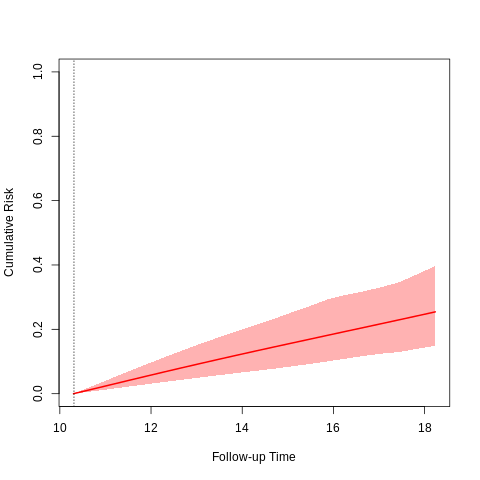

In [ ]:
%%R
plot(pred_dynamic)


This curve updates as the patient’s CD4 history is extended — illustrating **dynamic (real-time) prediction**.



### Dynamic predictive accuracy


Using the available longitudinal information up to a starting time point, `tvROV` fuctions compute estimates of the ROC curve and the AUC, the Brier score and expected predictive cross-entropy at a horizon time point based on joint models.


In [ ]:
%%R

# Evaluate Time-dependent ROC curve
roc <- tvROC(
  jmFit_static,
  newdata = aids,
  Tstart = 5,   # Landmark time (e.g., year 5)
  Dt = 3,       # Prediction horizon (5 → 8 years)
  cores = 1L
)

In [ ]:
%%R
# Print results
roc
tvAUC(roc)


	Time-dependent AUC for the Joint Model jmFit_static

Estimated AUC:  0.7386
At time: 8
Using information up to time: 5 (414 subjects still at risk)
Accounting for censoring using model-based weights



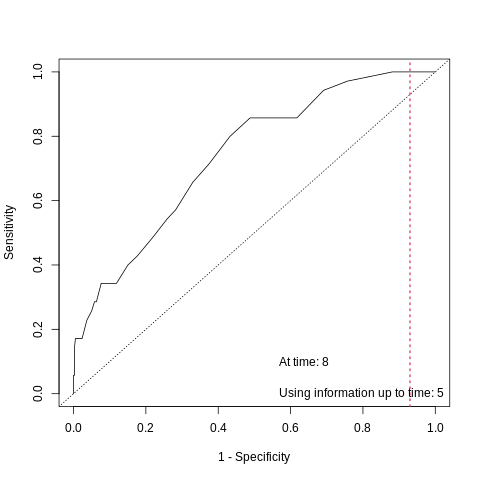

In [ ]:
%%R
# Plot ROC curve
plot(roc, legend = TRUE, optimal_cutoff = "Youden")

### Concept Recap


| Model Type             | Association                                                 | Purpose                                       |
| ---------------------- | ----------------------------------------------------------- | --------------------------------------------- |
| **Standard JM**        | Constant ( $\alpha$ )                                         | Simple, assumes biomarker effect constant     |
| **Dynamic JM**         | ( $\alpha(t)$) varies with time                              | Captures changing biomarker–risk relationship |
| **Dynamic Prediction** | Updated survival probability using recent biomarker history | Personalized forecasts                        |




## Summary and Conclusion


The Dynamic Joint Model extends the standard joint modeling framework by allowing the association between longitudinal biomarkers and survival risk to vary over time. This flexibility enables more accurate and personalized risk predictions that adapt as new biomarker data are collected. This tutorial demonstrated how to fit and interpret a **Dynamic Joint Model** in R using the `JMbayes2` package. At the end of tutorial you should be able to:

-  Understand the concept of dynamic joint modeling and its advantages over standard joint models.
-  Fit a dynamic joint model with time-varying association using R.
-  Generate and interpret dynamic survival predictions that update with new longitudinal data.
-  Evaluate the predictive accuracy of dynamic joint models using time-dependent ROC curves and AUC.
-  Appreciate the clinical utility of dynamic joint models for personalized medicine.


##  Resources


* Rizopoulos D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall/CRC.
* Rizopoulos D. (2023). *JMbayes2: Joint Models for Longitudinal and Survival Data using Bayesian Methods.*
* Proust-Lima, C., et al. (2014). *Joint modelling of multivariate longitudinal outcomes and time-to-event: a review.* Statistical Methods in Medical Research.
8 [JMbayes2: Extended Joint Models for Longitudinal and Time-to-Event Data](https://drizopoulos.github.io/JMbayes2/index.html)






